# dataset https://www.kaggle.com/datasets/dietzschenostoevsky/pizza-steak-sushi

In [8]:
!nvidia-smi

Fri Jan 19 14:44:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P0              32W /  70W |    600MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
!pip install kaggle

In [10]:
import os



userkaggle       = 'tuchsanai'
passkaggle       = '6fb3b161875d8dd03ab318c54701a8b7'

try :
    os.environ['KAGGLE_USERNAME'] = userkaggle
    os.environ['KAGGLE_KEY'] = passkaggle
except :
    print("KAGGLE_USERNAME or KAGGLE_KEY is not set.")
   






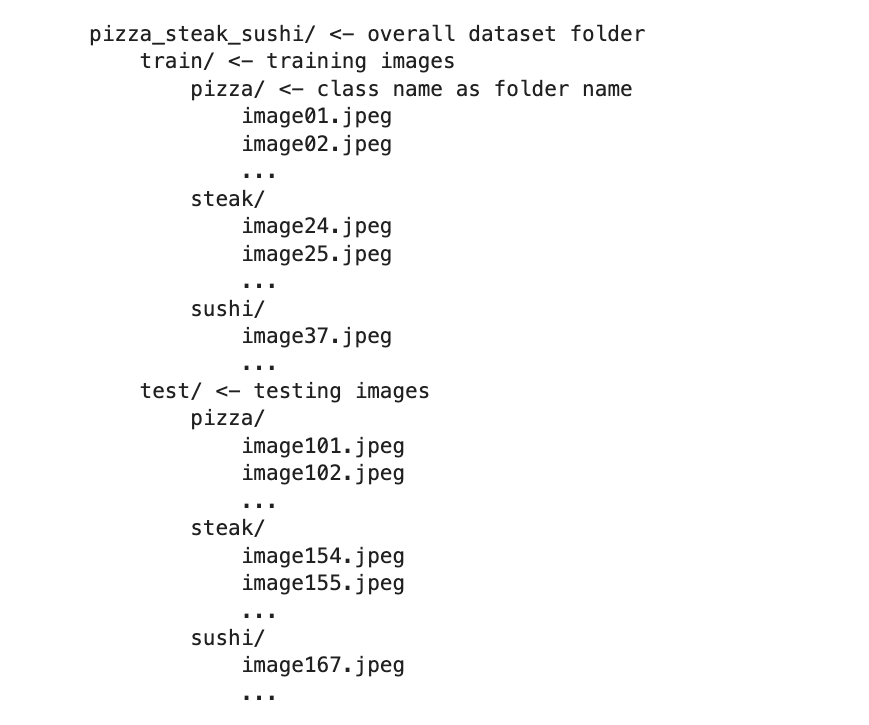

In [11]:
import os

if not os.path.exists('dogs-cats-images.zip'):
    # Download the dataset
    !kaggle datasets download -d dietzschenostoevsky/pizza-steak-sushi     

if os.path.exists('pizza-steak-sushi.zip') and not os.path.exists('pizza-steak-sushi'):
    # Make directory and unzip
    !unzip pizza-steak-sushi.zip -d pizza-steak-sushi



pizza-steak-sushi.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  pizza-steak-sushi.zip
  inflating: pizza-steak-sushi/data/pizza_steak_sushi/test/pizza/1001116.jpg  
  inflating: pizza-steak-sushi/data/pizza_steak_sushi/test/pizza/1032754.jpg  
  inflating: pizza-steak-sushi/data/pizza_steak_sushi/test/pizza/103708.jpg  
  inflating: pizza-steak-sushi/data/pizza_steak_sushi/test/pizza/1060407.jpg  
  inflating: pizza-steak-sushi/data/pizza_steak_sushi/test/pizza/106507.jpg  
  inflating: pizza-steak-sushi/data/pizza_steak_sushi/test/pizza/1067986.jpg  
  inflating: pizza-steak-sushi/data/pizza_steak_sushi/test/pizza/1106738.jpg  
  inflating: pizza-steak-sushi/data/pizza_steak_sushi/test/pizza/1119571.jpg  
  inflating: pizza-steak-sushi/data/pizza_steak_sushi/test/pizza/11297.jpg  
  inflating: pizza-steak-sushi/data/pizza_steak_sushi/test/pizza/1152100.jpg  
  inflating: pizza-steak-sushi/data/pizza_steak_sushi/test/pizza/1179703.jpg 

In [12]:
#%% packages
from typing import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils 

#%% Dataset and data loader
path_images = './pizza-steak-sushi/data/pizza_steak_sushi/train'
LATENT_DIMS = 128

transform = transforms.Compose(
    [transforms.Resize((64,64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))])




In [13]:
import glob
import random

subdirectory_path = path_images   # Replace with the actual subdirectory name
image_files = glob.glob(f'{path_images}/*/*.jpg')  # Replace '.jpg' with the file extension of your images

print(f'There are {len(image_files)} images in total in the subdirectory {subdirectory_path}')



There are 2250 images in total in the subdirectory ./pizza-steak-sushi/data/pizza_steak_sushi/train


In [14]:
random_images = random.sample(image_files, 700)
print("there are {} images in random_images".format(len(random_images)))



there are 700 images in random_images


# Delete not nessary files

In [15]:
import os

for image_file in image_files:
    if image_file not in random_images:
        os.remove(image_file)

image_files = glob.glob(f'{path_images}/*/*.jpg')  # Replace '.jpg' with the file extension of your images

print(f'There are {len(image_files)} images in total in the subdirectory ')

There are 700 images in total in the subdirectory 


In [16]:
import multiprocessing


dataset = ImageFolder(root=path_images , transform=transform)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True , num_workers=multiprocessing.cpu_count())
# %% model class


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


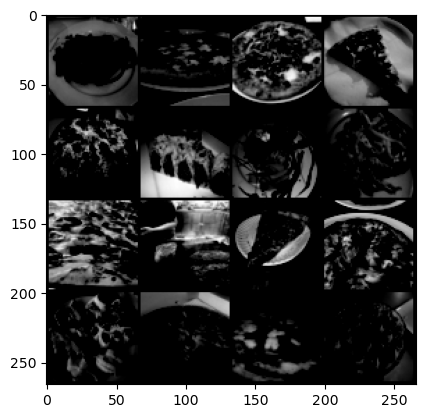

In [17]:
# %%
def imshow(image_torch): 
    # flip image channels to RGB
    image_torch = image_torch.numpy().transpose((1, 2, 0)) 
    plt.figure() 
    plt.imshow(image_torch) 
 
X_train, y_train = next(iter(dataloader)) 
 
# Make a grid from batch 
image_grid = torchvision.utils.make_grid(X_train[:16, :, :, :], scale_each= True, nrow=4) 
 
imshow(image_grid) 

In [18]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 6, 3)  # out: 6, 62, 62
        self.conv2 = nn.Conv2d(6, 16, 3) # out: 16, 60, 60
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() # out: 16*60*60 = 57600
        self.fc = nn.Linear(16*60*60, LATENT_DIMS)

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc = nn.Linear(LATENT_DIMS, 16*60*60)
        self.conv2 = nn.ConvTranspose2d(16, 6, 3)
        self.conv1 = nn.ConvTranspose2d(6, 1, 3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 16, 60, 60)  # infer first dim from other dims
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.relu(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Test it
input = torch.rand((1, 1, 64, 64))
model = Autoencoder()
model(input).shape

torch.Size([1, 1, 64, 64])

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [22]:
import time
NUM_EPOCHS = 800
model = Autoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model.to(device)

for epoch in range(NUM_EPOCHS):
    start_time = time.time()  # Start time of the epoch
    losses_epoch = []
    model.train()
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.view(-1, 1, 64, 64).to(device)
        output = model(data)

        loss = F.mse_loss(output, data)
        losses_epoch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 20 == 0:
        end_time = time.time()  # End time of the epoch
        epoch_time = end_time - start_time  # Time taken for the epoch
        print(f"Epoch: {epoch} \tLoss: {np.mean(losses_epoch)} \tTime per epoch: {epoch_time:05f} seconds")


Epoch: 0 	Loss: 0.4907233268022537 	Time per epoch: 2.055368 seconds
Epoch: 20 	Loss: 0.2696910628250667 	Time per epoch: 2.088696 seconds
Epoch: 40 	Loss: 0.2624099339757647 	Time per epoch: 2.009179 seconds
Epoch: 60 	Loss: 0.25825792231730055 	Time per epoch: 2.052145 seconds
Epoch: 80 	Loss: 0.2549118899873325 	Time per epoch: 2.043302 seconds
Epoch: 100 	Loss: 0.25180176751954214 	Time per epoch: 2.028196 seconds
Epoch: 120 	Loss: 0.24893268304211752 	Time per epoch: 2.011459 seconds
Epoch: 140 	Loss: 0.24617982230016164 	Time per epoch: 2.033928 seconds
Epoch: 160 	Loss: 0.2434547170996666 	Time per epoch: 2.118911 seconds
Epoch: 180 	Loss: 0.24074186278241022 	Time per epoch: 2.065204 seconds
Epoch: 200 	Loss: 0.2380492783018521 	Time per epoch: 2.027507 seconds
Epoch: 220 	Loss: 0.23538262929235185 	Time per epoch: 2.050016 seconds
Epoch: 240 	Loss: 0.2327860796025821 	Time per epoch: 2.047048 seconds
Epoch: 260 	Loss: 0.2303124474627631 	Time per epoch: 2.063313 seconds
Epoch:

original


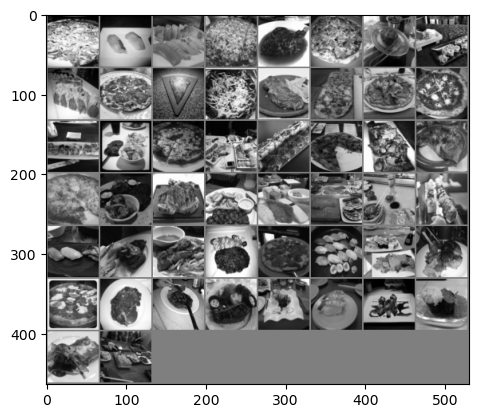

In [23]:

# %% visualise original and reconstructed images
def show_image(img):
    img = 0.5 * (img + 1)  # denormalizeA
    # img = img.clamp(0, 1) 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(dataloader))
print('original')
show_image(torchvision.utils.make_grid(images))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


latent space


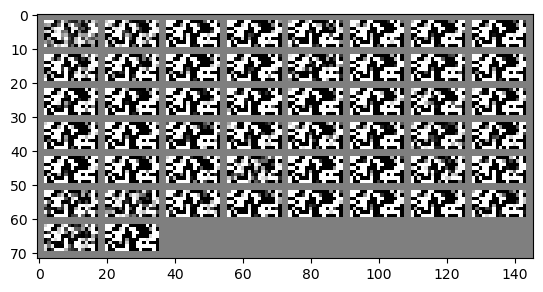

In [24]:
model.eval()    
images = images.to(device)
# %% latent space
print('latent space')
latent_img = model.encoder(images)
show_image(torchvision.utils.make_grid(latent_img.view(-1, 1, 8, 16).cpu()))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


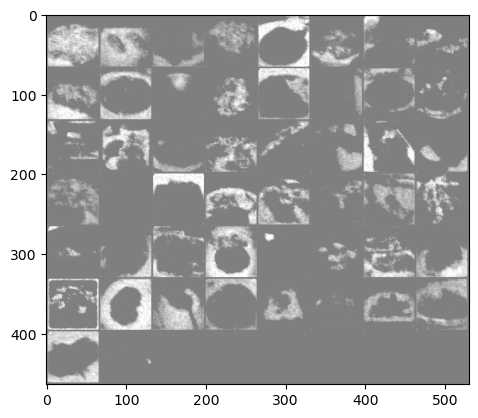

In [25]:
model.eval()
decoded_images = model.decoder(latent_img)
decoded_images = decoded_images.view(-1, 1, 64, 64).cpu()
show_image(torchvision.utils.make_grid(decoded_images))
